# Step 5 - Plotting bicycle network analysis results
## Project: Growing Urban Bicycle Networks

This notebook takes the results from 03_poi_based_generation and 04_analyze_results, and plots them.

Contact: Michael Szell (michael.szell@gmail.com)  
Created: 2020-07-08  
Last modified: 2021-11-16

## Preliminaries

### Parameters

In [1]:
debug = False # If True, will produce plots and/or verbose output to double-check
%run -i "../parameters/parameters.py"
plotconstricted = True # If True, will add plots about constricted street network metrics

Loaded parameters.



### Setup

In [9]:
%run -i path.py
%run -i setupCPH.py
if not debug: # Only do this if sure the code is bug-free!
    warnings.filterwarnings('ignore')

%load_ext watermark
%watermark -n -v -m -g -iv

Loaded PATH.

Setup finished.

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.8.2
IPython version      : 8.5.0

Compiler    : Clang 9.0.1 
OS          : Darwin
Release     : 18.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: 

shapely   : 1.8.4
fiona     : 1.8.21
osmnx     : 0.16.2
matplotlib: 3.6.0
csv       : 1.0
numpy     : 1.23.3
igraph    : 0.9.1
sys       : 3.8.2 | packaged by conda-forge | (default, Apr 24 2020, 07:56:27) 
[Clang 9.0.1 ]
osgeo     : 3.2.1
pyproj    : 3.4.0
pandas    : 1.4.4
networkx  : 2.8.6
geojson   : 2.5.0
geopandas : 0.11.1
watermark : 2.3.1



fatal: not a git repository (or any of the parent directories): .git


### Functions

In [10]:
%run -i functions.py

Loaded functions.



## Plot

Some plot functions love to plot inline. To suppress that and only export the plots, we use ``%%capture``.  
To check that plots are being generated while running the code below, go into the ``plots/placeid`` folder.

### Analysis plots

In [ ]:
# %%capture

# Run all parameter sets
poi_source_list = ["grid", "railwaystation"]
prune_measure_list = ["betweenness", "closeness", "random"]
parsets_used = list(itertools.product(poi_source_list, prune_measure_list))

for poi_source, prune_measure in parsets_used:
    print(poi_source, prune_measure)
        
        
    for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):

        # PLOT Analysis
        filename = placeid + '_poi_' + poi_source + "_" + prune_measure + ".csv"
        analysis_result = np.genfromtxt(PATH["results"] + placeid + "/" + filename, delimiter=',', names=True)
        if len(analysis_result) == 0: # No plot if no results (for example no railwaystations)
            print(placeid + ": No analysis results available")
            continue

        print(placeid + ": Plotting analysis results")

        # Load existing networks
        G_biketrack = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrack')
        G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall')
        G_bikeable = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'bikeable')
    #     G_biketrack_onstreet = intersect_igraphs(G_biketrack, G_carall)
    #     G_bikeable_onstreet = intersect_igraphs(G_bikeable, G_carall)


        filename = placeid + '_poi_' + poi_source + "_mst.csv"
        analysis_mst_result = np.genfromtxt(PATH["results"] + placeid + "/" + filename, delimiter=',', names=True)

        filename = placeid + "_existing.csv"
        analysis_existing = np.genfromtxt(PATH["results"] + placeid + "/" + filename, delimiter=',', names=True)
        
        prune_quantiles_constricted = prune_quantiles
        if plotconstricted:
            f = PATH["results_constricted"] + "results_" + poi_source + "_" + prune_measure + "/metrics_" + poi_source + "_" + prune_measure + "/" + placeid + "_carconstrictedbike_poi_" + poi_source + "_" + prune_measure + ".csv"
            if os.path.isfile(f):
                analysis_result_constricted = np.loadtxt(f, delimiter=',', usecols = (2,3,4,5,6,7,8,9,10), skiprows=1)
                if np.shape(analysis_result_constricted)[0] == 3: # for large cities we only calculated 3 values
                    prune_quantiles_constricted = [prune_quantiles[19], prune_quantiles[-1]]
                    
        nc = 5
        fig, axes = plt.subplots(nrows = 2, ncols = nc, figsize = (16, 6))
        # Bike network
        keys_metrics = {"length": "Length [km]","coverage": "Coverage [km$^2$]","overlap_biketrack": "Overlap Protected","directness_all_linkwise": "Directness","efficiency_global": "Global Efficiency",
                "length_lcc": "Length of LCC [km]","poi_coverage": "POIs covered","overlap_bikeable": "Overlap Bikeable","components": "Components","efficiency_local": "Local Efficiency"}
        
        for i, ax in enumerate(axes[0]):
            key = list(keys_metrics.keys())[i]
            if key in ["overlap_biketrack", "overlap_bikeable"]:
                ax.plot(prune_quantiles, analysis_result[key] / analysis_result["length"], **plotparam_analysis["bikegrown"])
            elif key in ["efficiency_global", "efficiency_local"]:
                ax.plot(prune_quantiles, analysis_result[key], **plotparam_analysis["bikegrown_abstract"])
                xmin, xmax = ax.get_xlim()
                tmp, = ax.plot([xmin, xmax], [analysis_mst_result[key], analysis_mst_result[key]], **plotparam_analysis["mst"])  # MST is equivalent for abstract and routed
                tmp.set_label('_hidden')
                tmp, = ax.plot(prune_quantiles, analysis_result[key+"_routed"], **plotparam_analysis["bikegrown"])
                tmp.set_label('_hidden')
            elif key in ["length", "length_lcc"]: # Convert m->km
                ax.plot(prune_quantiles, analysis_result[key]/1000, **plotparam_analysis["bikegrown"])
                xmin, xmax = ax.get_xlim()
                ax.plot([xmin, xmax], [analysis_mst_result[key]/1000, analysis_mst_result[key]/1000], **plotparam_analysis["mst"])
            else:
                ax.plot(prune_quantiles, analysis_result[key], **plotparam_analysis["bikegrown"])
                xmin, xmax = ax.get_xlim()
                ax.plot([xmin, xmax], [analysis_mst_result[key], analysis_mst_result[key]], **plotparam_analysis["mst"])
                
            try:
                if key in ["length", "length_lcc"]: # Convert m->km
                    tmp, = ax.plot([xmin, xmax], [analysis_existing[key][analysis_existing_rowkeys["biketrack"]]/1000, analysis_existing[key][analysis_existing_rowkeys["biketrack"]]/1000], **plotparam_analysis["biketrack"])
                else:
                    tmp, = ax.plot([xmin, xmax], [analysis_existing[key][analysis_existing_rowkeys["biketrack"]], analysis_existing[key][analysis_existing_rowkeys["biketrack"]]], **plotparam_analysis["biketrack"])
                if key in ["efficiency_global", "efficiency_local"]:
                    tmp.set_label('_hidden')

                if key in ["length", "length_lcc"]: # Convert m->km
                    tmp, = ax.plot([xmin, xmax], [analysis_existing[key][analysis_existing_rowkeys["bikeable"]]/1000, analysis_existing[key][analysis_existing_rowkeys["bikeable"]]/1000], **plotparam_analysis["bikeable"])
                else:
                    tmp, = ax.plot([xmin, xmax], [analysis_existing[key][analysis_existing_rowkeys["bikeable"]], analysis_existing[key][analysis_existing_rowkeys["bikeable"]]], **plotparam_analysis["bikeable"])
                if key in ["efficiency_global", "efficiency_local"]:
                    tmp.set_label('_hidden')
            except:
                pass

            if key == "efficiency_global" and plotconstricted:
                ax.plot([0]+prune_quantiles_constricted, analysis_result_constricted[:, 0], **plotparam_analysis["constricted"])

            if i == 0:
                ymax0 = ax.get_ylim()[1]
                ax.set_ylim(0, ymax0)
                ax.text(-0.15, ymax0*1.25, placeinfo['name'] + " (" + poi_source + " | " + prune_measure + ")", fontsize=16, horizontalalignment='left')
                ax.legend(loc = 'upper left')
            if i == 4:
                ax.legend(loc = 'best')

            if key == "directness_all_linkwise" and plotconstricted:
                ax.plot([0]+prune_quantiles_constricted, analysis_result_constricted[:, -1], **plotparam_analysis["constricted"])

            set_analysissubplot(key)
            ax.set_title(list(keys_metrics.values())[i])
            ax.set_xlabel('')
            ax.set_xticklabels([])


        for i, ax in enumerate(axes[1]):
            key = list(keys_metrics.keys())[i+nc]
            if key in ["overlap_biketrack", "overlap_bikeable"]:
                ax.plot(prune_quantiles, analysis_result[key] / analysis_result["length"], **plotparam_analysis["bikegrown"])
            elif key in ["efficiency_global", "efficiency_local"]:
                ax.plot(prune_quantiles, analysis_result[key], **plotparam_analysis["bikegrown_abstract"])
                xmin, xmax = ax.get_xlim()
                ax.plot([xmin, xmax], [analysis_mst_result[key], analysis_mst_result[key]], **plotparam_analysis["mst"]) # MST is equivalent for abstract and routed
                ax.plot(prune_quantiles, analysis_result[key+"_routed"], **plotparam_analysis["bikegrown"])
            elif key in ["length", "length_lcc"]: # Convert m->km
                ax.plot(prune_quantiles, analysis_result[key]/1000, **plotparam_analysis["bikegrown"])
                xmin, xmax = ax.get_xlim()
                ax.plot([xmin, xmax], [analysis_mst_result[key]/1000, analysis_mst_result[key]/1000], **plotparam_analysis["mst"])
            else:
                ax.plot(prune_quantiles, analysis_result[key], **plotparam_analysis["bikegrown"])
                xmin, xmax = ax.get_xlim()
                ax.plot([xmin, xmax], [analysis_mst_result[key], analysis_mst_result[key]], **plotparam_analysis["mst"])
            try:
                if key in ["length", "length_lcc"]: # Convert m->km
                    ax.plot([xmin, xmax], [analysis_existing[key][analysis_existing_rowkeys["biketrack"]]/1000, analysis_existing[key][analysis_existing_rowkeys["biketrack"]]/1000], **plotparam_analysis["biketrack"])
                    ax.plot([xmin, xmax], [analysis_existing[key][analysis_existing_rowkeys["bikeable"]]/1000, analysis_existing[key][analysis_existing_rowkeys["bikeable"]]/1000], **plotparam_analysis["bikeable"])
                else:
                    if not (key == "poi_coverage" and poi_source == "railwaystation"):
                        ax.plot([xmin, xmax], [analysis_existing[key][analysis_existing_rowkeys["biketrack"]], analysis_existing[key][analysis_existing_rowkeys["biketrack"]]], **plotparam_analysis["biketrack"])
                        ax.plot([xmin, xmax], [analysis_existing[key][analysis_existing_rowkeys["bikeable"]], analysis_existing[key][analysis_existing_rowkeys["bikeable"]]], **plotparam_analysis["bikeable"])
            except:
                pass
            if key == "efficiency_local" and plotconstricted:
                ax.plot([0]+prune_quantiles_constricted, analysis_result_constricted[:, 1], **plotparam_analysis["constricted"])

            if i == 0:
                ax.set_ylim(0, ymax0)
            set_analysissubplot(key)
            ax.set_title(list(keys_metrics.values())[i+nc])
            ax.set_xlabel(prune_measure + ' quantile')
            if key in ["poi_coverage"]:
                # https://stackoverflow.com/questions/30914462/matplotlib-how-to-force-integer-tick-labels
                ax.yaxis.set_major_locator(MaxNLocator(integer=True)) 

        plt.subplots_adjust(top = 0.87, bottom = 0.09, left = 0.05, right = 0.97, wspace = 0.25, hspace = 0.25)
        if plotconstricted:
            fig.savefig(PATH["plots"] + placeid + "/" + placeid + '_analysis_poi_' + poi_source + "_" + prune_measure + '.png', facecolor = "white", edgecolor = 'none')
        else:
            fig.savefig(PATH["plots"] + placeid + "/" + placeid + '_analysis_poi_' + poi_source + "_" + prune_measure + '_noconstr.png', facecolor = "white", edgecolor = 'none')
        plt.close()

### Constricted analysis plots

In [ ]:
# %%capture
for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    prune_measure_this = "betweenness"
    for poi_source_this in ["railwaystation", "grid"]:
        f = PATH["results_constricted"] + poi_source_this + "/" + placeid + constricted_parameternamemap[prune_measure_this] + constricted_parameternamemap[poi_source_this] + ".csv"
        if os.path.isfile(f):
            analysis_result_constricted = np.loadtxt(f, delimiter=',', usecols = (2,3,4,5,6,7,8,9,10), skiprows=1)

            fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (16, 3))

            for i, ax in enumerate(axes):
                ax.set_title(constricted_plotinfo["title"][i])
                ax.set_xlabel(prune_measure_this + ' quantile')
                ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
                ax.set_xlim(-0.05, 1.05)
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)

                # Efficiency global
                if i == 0:
                    ax.plot([0]+prune_quantiles, analysis_result_constricted[:, 0], **plotparam_analysis["constricted"])
                    ymin, ymax = ax.get_ylim()
                    ax.text(-0.25, ymin + (ymax-ymin)*1.2, placeinfo['name'] + " streets (" + poi_source_this + ", " + prune_measure_this + " growth)", fontsize=16, horizontalalignment='left')

                # Efficiency local
                elif i == 1:
                    ax.plot([0]+prune_quantiles, analysis_result_constricted[:, 1], **plotparam_analysis["constricted"])

                # Directness
                elif i == 2:
                    ax.plot([0]+prune_quantiles, analysis_result_constricted[:, -1], **plotparam_analysis["constricted"])

                # Clustering
                elif i == 3:
                    ax.plot([0]+prune_quantiles, analysis_result_constricted[:, 2], **plotparam_analysis["constricted_10"])
                    ax.plot([0]+prune_quantiles, analysis_result_constricted[:, 3], **plotparam_analysis["constricted_5"])
                    ax.plot([0]+prune_quantiles, analysis_result_constricted[:, 4], **plotparam_analysis["constricted_3"])
                    ax.legend(loc = 'best')

                # Anisotropy
                elif i == 4:
                    ax.plot([0]+prune_quantiles, analysis_result_constricted[:, 5], **plotparam_analysis["constricted_10"])
                    ax.plot([0]+prune_quantiles, analysis_result_constricted[:, 6], **plotparam_analysis["constricted_5"])
                    ax.plot([0]+prune_quantiles, analysis_result_constricted[:, 7], **plotparam_analysis["constricted_3"])
                    
            plt.subplots_adjust(top = 0.79, bottom = 0.16, left = 0.05, right = 0.97, wspace = 0.25)
            fig.savefig(PATH["plots"] + placeid + "/" + placeid + '_analysis_poi_' + poi_source_this + "_" + prune_measure_this + '_constricted.png', facecolor = "white", edgecolor = 'none')

### Network plots

#### Existing networks

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

copenhagen: Plotting networks


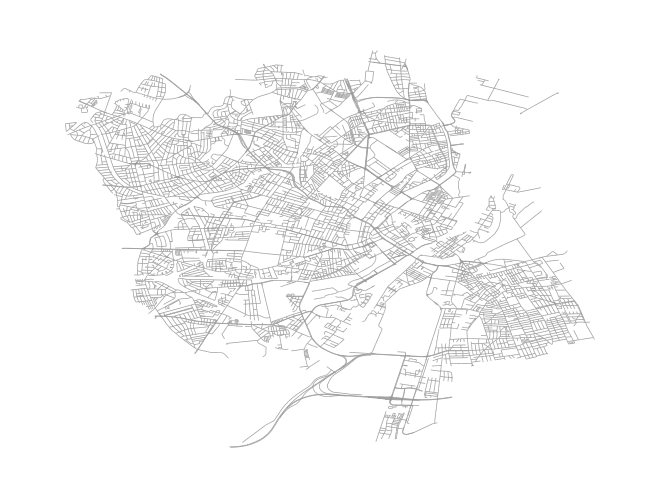

In [11]:
# %%capture
for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    print(placeid + ": Plotting networks")
    
    if prune_measure == "betweenness":
        weight_abstract = True
    else:
        weight_abstract = 6
    
    # EXISTING INFRASTRUCTURE
    # Load networks
    G_biketrack = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrack')
    G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall')
    G_biketrackcarall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
    G_bikeable = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'bikeable')
    map_center = nxdraw(G_carall, "carall")
    
    # PLOT existing networks
    fig = initplot()
    nxdraw(G_carall, "carall", map_center)
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_carall.pdf', bbox_inches="tight")
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_carall.png', bbox_inches="tight", dpi=plotparam["dpi"])
    plt.close()
    
    fig = initplot()
    nxdraw(G_biketrack, "biketrack", map_center)
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_biketrack.pdf', bbox_inches="tight")
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_biketrack.png', bbox_inches="tight", dpi=plotparam["dpi"])
    plt.close()
    
    fig = initplot()
    nxdraw(G_bikeable, "bikeable", map_center)
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_bikeable.pdf', bbox_inches="tight")
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_bikeable.png', bbox_inches="tight", dpi=plotparam["dpi"])
    plt.close()
    
    fig = initplot()
    nxdraw(G_carall, "carall", map_center)
    nxdraw(G_biketrack, "biketrack", map_center, list(set([v["id"] for v in G_biketrack.vs]).intersection(set([v["id"] for v in G_carall.vs]))))
    nxdraw(G_biketrack, "biketrack_offstreet", map_center, list(set([v["id"] for v in G_biketrack.vs]).difference(set([v["id"] for v in G_carall.vs]))))
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_biketrackcarall.pdf', bbox_inches="tight")
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_biketrackcarall.png', bbox_inches="tight", dpi=plotparam["dpi"])
    plt.close()
    
    # Load POIs
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + poi_source + '_nnidscarall.csv') as f:
        nnids = [int(line.rstrip()) for line in f]
    nodesize_poi = nodesize_from_pois(nnids)
    
    fig = initplot()
    nxdraw(G_carall, "carall", map_center)
    nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_carall_poi_' + poi_source + '.pdf', bbox_inches="tight")
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_carall_poi_' + poi_source + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
    plt.close()

#### Grown networks

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

copenhagen: Plotting networks


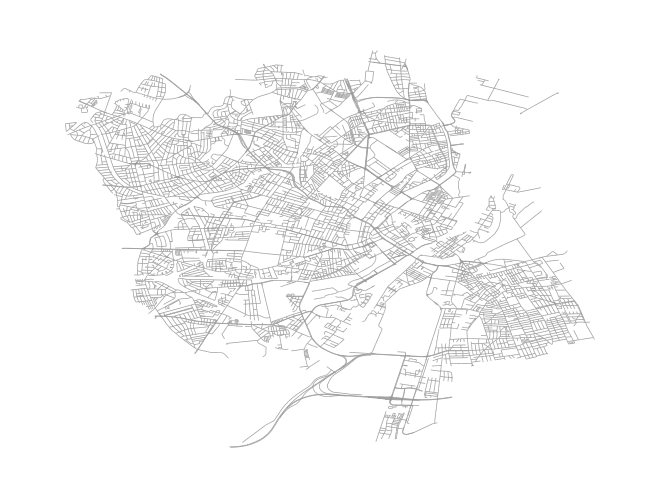

In [12]:
# %%capture
for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    print(placeid + ": Plotting networks")
    
    if prune_measure == "betweenness":
        weight_abstract = True
    else:
        weight_abstract = 6
    
    # EXISTING INFRASTRUCTURE
    # Load networks
    G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall')
    map_center = nxdraw(G_carall, "carall")
    
    # Load POIs
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + poi_source + '_nnidscarall.csv') as f:
        nnids = [int(line.rstrip()) for line in f]
    nodesize_poi = nodesize_from_pois(nnids)
    
    fig = initplot()
    nxdraw(G_carall, "carall", map_center)
    nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_carall_poi_' + poi_source + '.pdf', bbox_inches="tight")
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_carall_poi_' + poi_source + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
    plt.close()
    
    
    # GENERATED, POI BASED
    # Load results
    filename = placeid + '_poi_' + poi_source + "_" + prune_measure + ".pickle"
    with open(PATH["results"] + placeid + "/" + filename, 'rb') as f:
        res = pickle.load(f)
    if debug: pp.pprint(res)
        
    # PLOT abstract MST
    fig = initplot()
    nxdraw(G_carall, "carall", map_center)
    nxdraw(res["MST_abstract"], "abstract", map_center, weighted = 6)
    nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
    nxdraw(G_carall, "poi_reached", map_center, list(set([v["id"] for v in res["MST"].vs]).intersection(set(nnids))), "nx.draw_networkx_nodes", nodesize_poi)
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_MSTabstract_poi_' + poi_source + '.pdf', bbox_inches="tight")
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_MSTabstract_poi_' + poi_source + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
    plt.close()
    
    # PLOT MST all together
    fig = initplot()
    nxdraw(G_carall, "carall")
    nxdraw(res["MST"], "bikegrown", map_center, nodesize = nodesize_grown)
    nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
    nxdraw(G_carall, "poi_reached", map_center, list(set([v["id"] for v in res["MST"].vs]).intersection(set(nnids))), "nx.draw_networkx_nodes", nodesize_poi)
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_MSTall_poi_' + poi_source + '.pdf', bbox_inches="tight")
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_MSTall_poi_' + poi_source + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
    plt.close()
    
    # PLOT MST all together with abstract
    fig = initplot()
    nxdraw(G_carall, "carall", map_center)
    nxdraw(res["MST"], "bikegrown", map_center, nodesize = 0)
    nxdraw(res["MST_abstract"], "abstract", map_center, weighted = 6)
    nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
    nxdraw(G_carall, "poi_reached", map_center, list(set([v["id"] for v in res["MST"].vs]).intersection(set(nnids))), "nx.draw_networkx_nodes", nodesize_poi)
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_MSTabstractall_poi_' + poi_source + '.pdf', bbox_inches="tight")
    plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_MSTabstractall_poi_' + poi_source + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
    plt.close()
    
    # PLOT abstract greedy triangulation (this can take some minutes)
    for GT_abstract, prune_quantile in zip(res["GT_abstracts"], res["prune_quantiles"]):
        fig = initplot()
        nxdraw(G_carall, "carall")
        try:
            GT_abstract.es["weight"] = GT_abstract.es["width"]
        except:
            pass
        nxdraw(GT_abstract, "abstract", map_center, drawfunc = "nx.draw_networkx_edges", nodesize = 0, weighted = weight_abstract, maxwidthsquared = nodesize_poi)
        nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
        nxdraw(G_carall, "poi_reached", map_center, list(set([v["id"] for v in GT_abstract.vs]).intersection(set(nnids))), "nx.draw_networkx_nodes", nodesize_poi)
        plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_GTabstract_poi_' + poi_source + "_" + prune_measures[prune_measure] + "{:.3f}".format(prune_quantile) + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
        plt.close()
    
    # PLOT all together (this can take some minutes)
    for GT, prune_quantile in zip(res["GTs"], res["prune_quantiles"]):
        fig = initplot()
        nxdraw(G_carall, "carall")
        nxdraw(GT, "bikegrown", map_center, nodesize = nodesize_grown)
        nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
        nxdraw(G_carall, "poi_reached", map_center, list(set([v["id"] for v in GT.vs]).intersection(set(nnids))), "nx.draw_networkx_nodes", nodesize_poi)
        plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_GTall_poi_' + poi_source + "_" + prune_measures[prune_measure] + "{:.3f}".format(prune_quantile) + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
        plt.close()
        

#### Networks with overlap with existing bicycle infra

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

copenhagen: Plotting networks


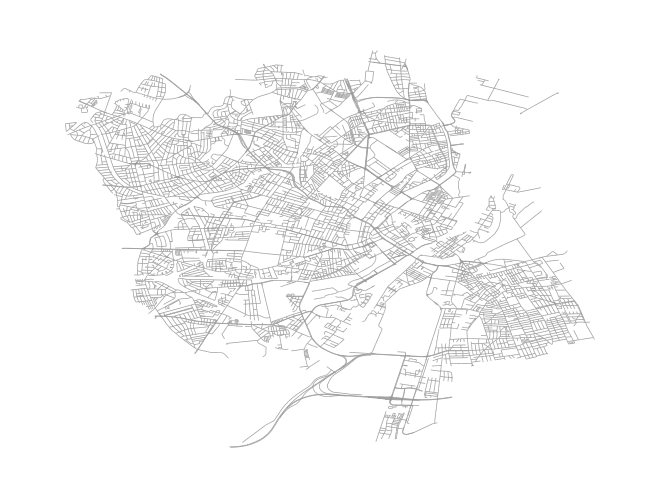

In [13]:
# %%capture
for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    print(placeid + ": Plotting networks")
    
    # Load results
    filename = placeid + '_poi_' + poi_source + "_" + prune_measure + ".pickle"
    with open(PATH["results"] + placeid + "/" + filename, 'rb') as f:
        res = pickle.load(f)
        
    # Load POIs
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + poi_source + '_nnidscarall.csv') as f:
        nnids = [int(line.rstrip()) for line in f]
    nodesize_poi = nodesize_from_pois(nnids)
        
    # EXISTING INFRASTRUCTURE
    # Load networks
    G_biketrack = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrack')
    G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall')
    G_biketrackcarall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
    G_bikeable = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'bikeable')
    map_center = nxdraw(G_carall, "carall")
    
    # PLOT all together with overlaps (this can take some minutes)
    for GT, prune_quantile in zip(res["GTs"], res["prune_quantiles"]):
        fig = initplot()
        nxdraw(G_carall, "carall")
        nxdraw(G_biketrack, "biketrack", map_center, list(set([v["id"] for v in G_biketrack.vs]).intersection(set([v["id"] for v in G_carall.vs]))))
        nxdraw(GT, "bikegrown", map_center, nodesize = 0)
        nxdraw(GT, "highlight_biketrack", map_center, list(set([v["id"] for v in G_biketrack.vs]).intersection(set([v["id"] for v in GT.vs]))))
#         nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
#         nxdraw(G_carall, "poi_reached", map_center, list(set([v["id"] for v in GT.vs]).intersection(set(nnids))), "nx.draw_networkx_nodes", nodesize_poi)
        plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_GTalloverlapbiketrack_poi_' + poi_source + "_" + prune_measures[prune_measure] + "{:.3f}".format(prune_quantile) + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
        plt.close()
        
    for GT, prune_quantile in zip(res["GTs"], res["prune_quantiles"]):
        fig = initplot()
        nxdraw(G_carall, "carall")
        nxdraw(G_bikeable, "bikeable", map_center, list(set([v["id"] for v in G_bikeable.vs]).intersection(set([v["id"] for v in G_carall.vs]))))
        nxdraw(GT, "bikegrown", map_center, nodesize = 0)
        nxdraw(GT, "highlight_bikeable", map_center, list(set([v["id"] for v in G_bikeable.vs]).intersection(set([v["id"] for v in GT.vs]))))
        nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
        nxdraw(G_carall, "poi_reached", map_center, list(set([v["id"] for v in GT.vs]).intersection(set(nnids))), "nx.draw_networkx_nodes", nodesize_poi)
        plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_GTalloverlapbikeable_poi_' + poi_source + "_" + prune_measures[prune_measure] + "{:.3f}".format(prune_quantile) + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
        plt.close()

#### Cover plots

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

copenhagen: Plotting network covers


FileNotFoundError: [Errno 2] No such file or directory: '../../bikenwgrowth_external/results/copenhagen/copenhagen_poi_grid_betweenness_covers.pickle'

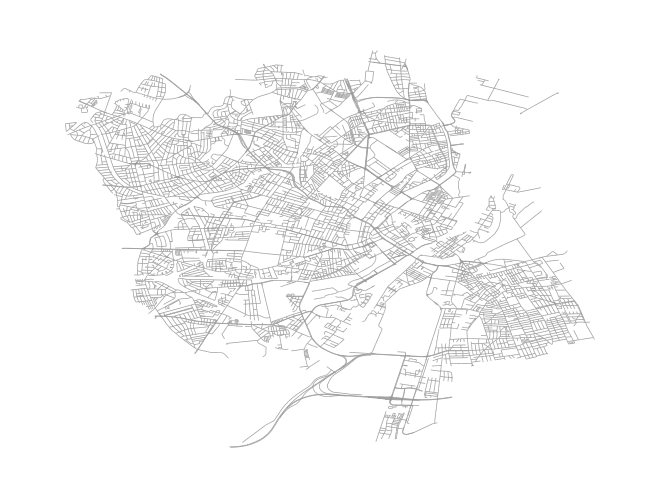

In [14]:
# %%capture
for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    print(placeid + ": Plotting network covers")

    # Load networks
    G_biketrack = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrack')
    G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'carall')
    G_biketrackcarall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
    G_bikeable = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'bikeable')
    map_center = nxdraw(G_carall, "carall")
    
    # Load POIs
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + poi_source + '_nnidscarall.csv') as f:
        nnids = [int(line.rstrip()) for line in f]
    nodesize_poi = nodesize_from_pois(nnids)
    
    # Load results
    filename = placeid + '_poi_' + poi_source + "_" + prune_measure + ".pickle"
    with open(PATH["results"] + placeid + "/" + filename, 'rb') as f:
        res = pickle.load(f)
    
    # Load covers
    filename = placeid + '_poi_' + poi_source + "_" + prune_measure + "_covers"
    with open(PATH["results"] + placeid + "/" + filename + ".pickle",'rb') as f:
        covs = pickle.load(f)
    filename = placeid + "_"  + "existing_covers"
    with open(PATH["results"] + placeid + "/" + filename + ".pickle",'rb') as f:
        cov_car = pickle.load(f)['carall']
    
    # Construct and plot patches from covers
    patchlist_car, patchlist_car_holes = cov_to_patchlist(cov_car, map_center)
    for GT, prune_quantile, cov in zip(res["GTs"], res["prune_quantiles"], covs.values()):
        fig = initplot()
        
        # Covers
        axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)
        patchlist_bike, patchlist_bike_holes = cov_to_patchlist(cov, map_center)
        
        # We have this contrived order due to alphas, holes, and matplotlib's inability to draw polygon patches with holes. This only works because the car network is a superset of the bike network.
        # car orange, bike white, bike blue, bike holes white, bike holes orange, car holes white
        patchlist_combined = patchlist_car + patchlist_bike + patchlist_bike + patchlist_bike_holes+ patchlist_bike_holes + patchlist_car_holes
        pc = PatchCollection(patchlist_combined)
        colors = np.array([[255/255,115/255,56/255,0.2] for _ in range(len(patchlist_car))]) # car orange
        if len(patchlist_bike):
            colors = np.append(colors, [[1,1,1,1] for _ in range(len(patchlist_bike))], axis = 0) # bike white
            colors = np.append(colors, [[86/255,220/255,244/255,0.4] for _ in range(len(patchlist_bike))], axis = 0) # bike blue
        if len(patchlist_bike_holes):
            colors = np.append(colors, [[1,1,1,1] for _ in range(len(patchlist_bike_holes))], axis = 0) # bike holes white
        if len(patchlist_bike_holes):
            colors = np.append(colors, [[255/255,115/255,56/255,0.2] for _ in range(len(patchlist_bike_holes))], axis = 0) # bike holes orange
        if len(patchlist_car_holes):
            colors = np.append(colors, [[1,1,1,1] for _ in range(len(patchlist_car_holes))], axis = 0) # car holes white
        pc.set_facecolors(colors)
        pc.set_edgecolors(np.array([[0,0,0,0.4] for _ in range(len(patchlist_combined))])) # remove this line if the outline of the full coverage should remain
        axes.add_collection(pc)
        axes.set_aspect('equal')
        axes.set_xmargin(0.01)
        axes.set_ymargin(0.01)
        axes.plot()
        
        # Networks
        nxdraw(G_carall, "carall", map_center)
        nxdraw(GT, "bikegrown", map_center, nodesize = nodesize_grown)
        nxdraw(G_carall, "poi_unreached", map_center, nnids, "nx.draw_networkx_nodes", nodesize_poi)
        nxdraw(G_carall, "poi_reached", map_center, list(set([v["id"] for v in GT.vs]).intersection(set(nnids))), "nx.draw_networkx_nodes", nodesize_poi)
        plt.savefig(PATH["plots_networks"] + placeid + "/" + placeid + '_GTallcover_poi_' + poi_source + "_" + prune_measures[prune_measure] + "{:.3f}".format(prune_quantile) + '.png', bbox_inches="tight", dpi=plotparam["dpi"])
        plt.close()

In [ ]:
Audio(sound_file, autoplay=True)